In [1]:
#Required imports
import matplotlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from math import pi
from sklearn.model_selection import train_test_split

In [2]:
#Load data
data = np.load("mlDataPredictionsNewNorm.npy").T
rawRecoData = data[4:8,:]
genData = data[12:16]
correctedRecoData = data[8:12]

#Normalize data
normInfoIn=[[0,1],[0,1],[0,1],[0,1]]
normInfoOut=[[0,1],[0,1],[0,1],[0,1]]
rawRecoData[0,:] = np.log(rawRecoData[0,:])
rawRecoData[3,:] = np.log(rawRecoData[3,:])
genData[0,:] = np.log(genData[0,:])
genData[3,:] = np.log(genData[3,:])


inputData=rawRecoData
outputData=genData

#Get datasets
trainIn, testIn, trainOut, testOut = train_test_split(inputData.T,
                                                    outputData.T,
                                                    test_size=1/10,
                                                    random_state=42)
_, _, _, recoCorrected = train_test_split(inputData.T,
                                                    correctedRecoData.T,
                                                    test_size=1/10,
                                                    random_state=42)

rawRecoData = trainIn.T
genData = trainOut.T
testIn = testIn.T
testOut = testOut.T
for x in range(4):
    if(x!=2):
        normInfoIn[x]=[np.mean(rawRecoData[x,:]),np.std(rawRecoData[x,:])]
        normInfoOut[x]=[np.mean(genData[x,:]),np.std(genData[x,:])]
        genData[x,:]=(genData[x,:]-np.mean(genData[x,:]))/(np.std(genData[x,:]))
        rawRecoData[x,:]=(rawRecoData[x,:]-np.mean(rawRecoData[x,:]))/(np.std(rawRecoData[x,:]))
    testIn[x] = (testIn[x]-normInfoIn[x][0])/normInfoIn[x][1]
    testOut[x] = (testOut[x]-normInfoOut[x][0])/normInfoOut[x][1]

inputData=rawRecoData
outputData=genData

In [3]:

#Metrics
def loss(y_actual, y_pred):
    custom_loss = tf.where(tf.math.square(tf.math.subtract(y_actual[:,2], y_pred[:,1]))<tf.math.square(tf.math.subtract(y_actual[:,2], y_pred[:,2]+2*pi)),
                           tf.math.subtract(y_actual[:,2], y_pred[:,2]), 
                           tf.math.subtract(y_actual[:,2], y_pred[:,2]+2*pi))
    custom_loss = tf.where(tf.math.square(custom_loss)<tf.math.square(tf.math.subtract(y_actual[:,2], y_pred[:,2]-2*pi)),
                           custom_loss,
                           tf.math.subtract(y_actual[:,2], y_pred[:,2]-2*pi))
    custom_loss = tf.reduce_mean(tf.math.square(custom_loss))
    
    custom_loss += tf.reduce_mean(tf.square(y_actual[:,0]-y_pred[:,0]))
    custom_loss += tf.reduce_mean(tf.square(y_actual[:,1]-y_pred[:,1]))
    custom_loss += tf.reduce_mean(tf.square(y_actual[:,3]-y_pred[:,3]))
    
    return custom_loss

def ptLoss(y_actual, y_pred):
    return(tf.reduce_mean(tf.square(y_actual[:,0]-y_pred[:,0])))

def etaLoss(y_actual, y_pred):
    return(tf.reduce_mean(tf.square(y_actual[:,1]-y_pred[:,1])))

def phiLoss(y_actual, y_pred):
    custom_loss = tf.where(tf.math.square(tf.math.subtract(y_actual[:,2], y_pred[:,1]))<tf.math.square(tf.math.subtract(y_actual[:,2], y_pred[:,2]+2*pi)),
                           tf.math.subtract(y_actual[:,2], y_pred[:,2]), 
                           tf.math.subtract(y_actual[:,2], y_pred[:,2]+2*pi))
    custom_loss = tf.where(tf.math.square(custom_loss)<tf.math.square(tf.math.subtract(y_actual[:,2], y_pred[:,2]-2*pi)),
                           custom_loss,
                           tf.math.subtract(y_actual[:,2], y_pred[:,2]-2*pi))
    custom_loss = tf.where(custom_loss<0.0, (tf.transpose(y_actual)[1]-1)*custom_loss, tf.transpose(y_actual)[1]*custom_loss)
    custom_loss = tf.reduce_mean(custom_loss)
    return(custom_loss)

def eLoss(y_actual, y_pred):
    return(tf.reduce_mean(tf.square(y_actual[:,3]-y_pred[:,3])))



testIn = testIn.astype(np.float32)
testOut = testOut.astype(np.float32)
trainIn = trainIn.astype(np.float32)
trainOut = trainOut.astype(np.float32)

newIn=[]
newOut=[]
newReco=[]
testIn = testIn.T
testOut = testOut.T
minPt=100
maxPt=120

#Select examples
for x in range(len(testIn)):
    #val = np.exp(testIn[x,0]*normInfoIn[0][1]+normInfoIn[0][0])
    #Raw reco delta
    
    #val = np.exp(testOut[x,0]*normInfoOut[0][1]+normInfoOut[0][0])
    #Gen delta
    
    val=110
    #All data
    if(val < maxPt and val > minPt):
        newIn.append(testIn[x])
        newOut.append(testOut[x])
        newReco.append(recoCorrected[x])
newIn = np.array(newIn)
newOut = np.array(newOut)
newReco = np.array(newReco)

#Make predictions
model = tf.keras.models.load_model("raw_to_gen_base", custom_objects={"loss": loss, "ptLoss": ptLoss, "etaLoss": etaLoss, "phiLoss": phiLoss, "eLoss": eLoss})
testPredInit = np.array(model.predict(newIn))


(21052, 4) (21052, 4) (21052, 4)


In [4]:
#Do some calculations

ptRawReco = np.exp(newIn.T[0]*normInfoIn[0][1]+normInfoIn[0][0])
ptGen = np.exp(newOut.T[0]*normInfoOut[0][1]+normInfoOut[0][0])
ptReco = newReco.T[0]
ptPredicted = np.exp(testPredInit.T[0]*normInfoOut[0][1]+normInfoOut[0][0])

etaRawReco = newIn.T[1]*normInfoIn[1][1]+normInfoIn[1][0]
etaGen = newOut.T[1]*normInfoOut[1][1]+normInfoOut[1][0]
etaReco = newReco.T[1]
etaPredicted = testPredInit.T[1]*normInfoOut[1][1]+normInfoOut[1][0]

phiRawReco = (newIn.T[2]*normInfoIn[2][1]+normInfoIn[2][0])%(2*pi)
phiGen = (newOut.T[2]*normInfoOut[2][1]+normInfoOut[2][0])%(2*pi)
phiReco = newReco.T[2]%(2*pi)
phiPred = (testPredInit.T[2]*normInfoOut[2][1]+normInfoOut[2][0])%(2*pi)


dPhi2Pred = np.minimum(np.square(phiGen-phiPred), np.square(phiPred-phiGen))
dPhi2Reco = np.minimum(np.square(phiGen-phiReco), np.square(phiReco-phiGen))
dPhi2Raw = np.minimum(np.square(phiGen-phiRawReco), np.square(phiRawReco-phiGen))


dEta2Pred = np.square(etaGen-etaPredicted)
dEta2Reco = np.square(etaGen-etaReco)
dEta2Raw = np.square(etaGen-etaRawReco)

dRPred = np.sqrt(dEta2Pred+dPhi2Pred)
dRReco = np.sqrt(dEta2Reco+dPhi2Reco)
dRRaw = np.sqrt(dEta2Raw+dPhi2Raw)


ptRatioPred = np.abs(ptPredicted)/ptGen
ptRatioReco = np.abs(ptReco)/ptGen
ptRatioRaw = np.abs(ptRawReco)/ptGen

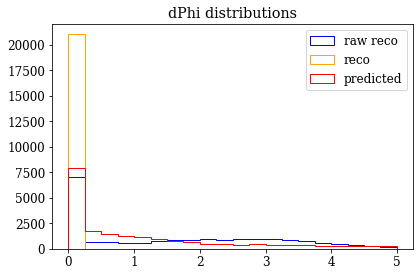

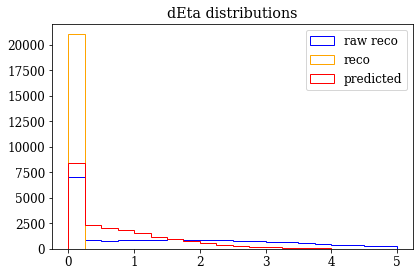

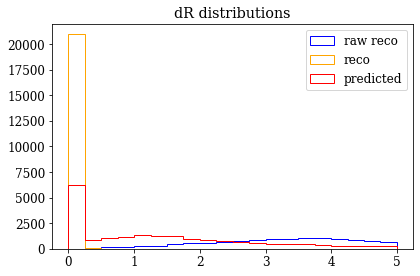

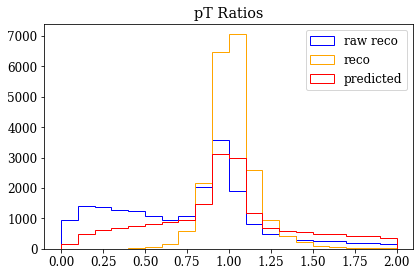

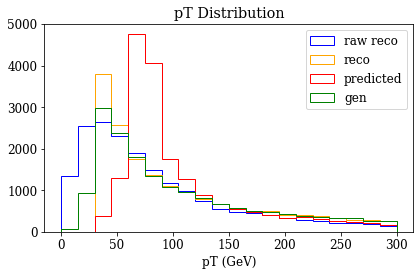

In [5]:
font = {'family' : 'serif',
        'size'   : 12}

matplotlib.rc('font', **font)
#Make some plots

bins=20
plt.figure(figsize=(6,4))
plt.hist(np.sqrt(dPhi2Raw), range=(0,5), bins=bins, label="raw reco", histtype="step", color="b")
plt.hist(np.sqrt(dPhi2Reco), range=(0,5), bins=bins, label="reco", histtype="step", color="orange")
plt.hist(np.sqrt(dPhi2Pred), range=(0,5), bins=bins, label="predicted", histtype="step", color="red")
plt.legend()
plt.title("dPhi distributions")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(np.sqrt(dEta2Raw), range=(0,5), bins=bins, label="raw reco", histtype="step", color="b")
plt.hist(np.sqrt(dEta2Reco), range=(0,5), bins=bins, label="reco", histtype="step", color="orange")
plt.hist(np.sqrt(dEta2Pred), range=(0,5), bins=bins, label="predicted", histtype="step", color="red")
plt.legend()
plt.title("dEta distributions")
plt.tight_layout()
plt.show()


plt.figure()
plt.hist(dRRaw, range=(0,5), bins=bins, label="raw reco", histtype="step", color="b")
plt.hist(dRReco, range=(0,5), bins=bins, label="reco", histtype="step", color="orange")
plt.hist(dRPred, range=(0,5), bins=bins, label="predicted", histtype="step", color="red")
plt.legend()
plt.title("dR distributions")
plt.tight_layout()
plt.show()


plt.figure()
plt.hist(ptRatioRaw, range=(0,2), bins=bins, label="raw reco", histtype="step", color="b")
plt.hist(ptRatioReco, range=(0,2), bins=bins, label="reco", histtype="step", color="orange")
plt.hist(ptRatioPred, range=(0,2), bins=bins, label="predicted", histtype="step", color="red")
plt.legend()
plt.title("pT Ratios")
plt.tight_layout()
plt.show()


plt.figure()
plt.hist(ptRawReco, range=(0,300), bins=bins, label="raw reco", histtype="step", color="b")
plt.hist(ptReco, range=(0,300), bins=bins, label="reco", histtype="step", color="orange")
plt.hist(ptPredicted, range=(0,300), bins=bins, label="predicted", histtype="step", color="r")
plt.hist(ptGen, range=(0,300), bins=bins, label="gen", histtype="step", color="g")
plt.xlabel("pT (GeV)")
plt.legend()
plt.title("pT Distribution")
plt.tight_layout()
plt.show()